# COGS 108 - EDA Checkpoint

# Names

- Yixuan Jiao
- Dat Ta
- Antonio (jose) Gomez
- Albert

<a id='research_question'></a>
# Research Question

Do Americans living in poor households (income below U.S. Federal Poverty threshold) get/contract Covid at a higher rate?

# Setup

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm

# Data Cleaning

Describe your data cleaning steps here.

In [2]:
# Loading states covid data
# A county covid dataset are also available under the same resporitory, we could retrieve it as we need following the same procedure like retrieving this one.
covid_states = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')
covid_states.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [3]:
covid_states.shape

(44750, 5)

In [4]:
#it is already very clean table
covid_states.isnull().values.any()

False

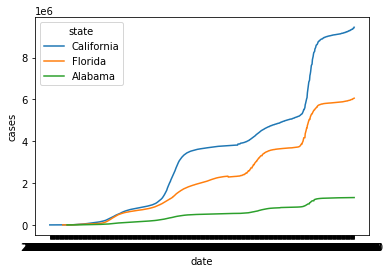

In [5]:
#plotting some states' cases over data further more validate the dataset since this trend make sense and that reminds us to get some population dataset to normalize the count.
covid_states_sub = covid_states[covid_states['state'].isin(['California','Florida','Alabama'])]
states_lineplot = sns.lineplot(x = covid_states_sub['date'], y = covid_states_sub['cases'], hue = covid_states_sub['state'])

In [6]:
covid_states = covid_states.drop('fips',axis = 1)
covid_states = covid_states.groupby('state').agg('max').reset_index()
covid_states.head()

,state,date,cases,deaths
0,Alabama,2022-05-20,1307883,19645
1,Alaska,2022-05-20,256415,1246
2,American Samoa,2022-05-20,6011,30
3,Arizona,2022-05-20,2038129,30259
4,Arkansas,2022-05-20,840151,11432


In [7]:
#Loading population dataset
county_population = pd.read_csv('https://www2.census.gov/programs-surveys/popest/datasets/2020-2021/counties/totals/co-est2021-alldata.csv',encoding='latin-1')

In [8]:
county_population.head()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,ESTIMATESBASE2020,POPESTIMATE2020,POPESTIMATE2021,...,RESIDUAL2021,GQESTIMATESBASE2020,GQESTIMATES2020,GQESTIMATES2021,RBIRTH2021,RDEATH2021,RNATURALCHG2021,RINTERNATIONALMIG2021,RDOMESTICMIG2021,RNETMIG2021
0,40,3,6,1,0,Alabama,Alabama,5024279,5024803,5039877,...,242,114572,114572,114572,11.191613,12.890226,-1.698613,0.247201,4.398749,4.645950
1,50,3,6,1,1,Alabama,Autauga County,58805,58877,59095,...,8,442,442,442,11.002611,11.545112,-0.542502,0.084766,4.017903,4.102668
2,50,3,6,1,3,Alabama,Baldwin County,231767,233140,239294,...,-82,2177,2177,2177,9.567474,12.137145,-2.569671,0.266704,28.702422,28.969126
3,50,3,6,1,5,Alabama,Barbour County,25223,25180,24964,...,1,2789,2789,2789,10.928526,15.714742,-4.786216,0.039885,-3.908743,-3.868858
4,50,3,6,1,7,Alabama,Bibb County,22293,22223,22477,...,-1,2062,2062,2062,10.111857,12.617450,-2.505593,0.089485,13.825503,13.914989


In [9]:
county_population.columns

Index(['SUMLEV', 'REGION', 'DIVISION', 'STATE', 'COUNTY', 'STNAME', 'CTYNAME',
       'ESTIMATESBASE2020', 'POPESTIMATE2020', 'POPESTIMATE2021',
       'NPOPCHG2020', 'NPOPCHG2021', 'BIRTHS2020', 'BIRTHS2021', 'DEATHS2020',
       'DEATHS2021', 'NATURALCHG2020', 'NATURALCHG2021',
       'INTERNATIONALMIG2020', 'INTERNATIONALMIG2021', 'DOMESTICMIG2020',
       'DOMESTICMIG2021', 'NETMIG2020', 'NETMIG2021', 'RESIDUAL2020',
       'RESIDUAL2021', 'GQESTIMATESBASE2020', 'GQESTIMATES2020',
       'GQESTIMATES2021', 'RBIRTH2021', 'RDEATH2021', 'RNATURALCHG2021',
       'RINTERNATIONALMIG2021', 'RDOMESTICMIG2021', 'RNETMIG2021'],
      dtype='object')

In [10]:
county_population.shape

(3194, 35)

In [11]:
county_population = county_population.iloc[:,[5,6,8,9]]
county_population.columns = ['state','county','pop_estimate_2020','pop_estimate_2021']
county_population.head()

,state,county,pop_estimate_2020,pop_estimate_2021
0,Alabama,Alabama,5024803,5039877
1,Alabama,Autauga County,58877,59095
2,Alabama,Baldwin County,233140,239294
3,Alabama,Barbour County,25180,24964
4,Alabama,Bibb County,22223,22477


In [12]:
#found some states' population stats in that we potentially need that
state_population = county_population[county_population['county'] == county_population['state']].drop('county',axis = 1)
state_population = state_population.drop(328)
state_population.head()

,state,pop_estimate_2020,pop_estimate_2021
0,Alabama,5024803,5039877
68,Alaska,732441,732673
99,Arizona,7177986,7276316
115,Arkansas,3012232,3025891
191,California,39499738,39237836


In [13]:
#delete those rows from our county population dataset since those rows are not showing counties' population
county_population = county_population[county_population['county'] != county_population['state']]

In [14]:
eda_df = covid_states.merge(state_population,how = 'inner',on = 'state')
eda_df.head()

,state,date,cases,deaths,pop_estimate_2020,pop_estimate_2021
0,Alabama,2022-05-20,1307883,19645,5024803,5039877
1,Alaska,2022-05-20,256415,1246,732441,732673
2,Arizona,2022-05-20,2038129,30259,7177986,7276316
3,Arkansas,2022-05-20,840151,11432,3012232,3025891
4,California,2022-05-20,9449358,91203,39499738,39237836


In [15]:
# following 2 cells is only for colab

# Code to read csv file into Colaboratory:
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [16]:
# link = 'https://drive.google.com/file/d/1GFKk2uMyuj10acUOmztSAP9kOE1P-uHj/view?usp=sharing'
# import pandas as pd
 
# to get the id part of the file
# id = link.split("/")[-2]
 
# downloaded = drive.CreateFile({'id':id})
# downloaded.GetContentFile('xclara.csv') 
 
# poverty_df = pd.read_csv('xclara.csv')
# poverty_df.head()


In [17]:
# loading in poverty dataset
# this cell is for notebook and github
poverty_df = pd.read_csv('./SAIPESNC_18MAY22_16_38_35_19.csv')
poverty_df.head()

,Year,State,County ID,State / County Name,All Ages SAIPE Poverty Universe,All Ages in Poverty Count,All Ages in Poverty Count LB 90%,All Ages in Poverty Count UB 90%,90% Confidence Interval (All Ages in Poverty Count),All Ages in Poverty Percent,...,Under Age 5 in Poverty Count UB 90%,90% Confidence Interval (Under Age 5 in Poverty Count),Under Age 5 in Poverty Percent,Under Age 5 in Poverty Percent LB 90%,Under Age 5 in Poverty Percent UB 90%,90% Confidence Interval (Under Age 5 in Poverty Percent),Median Household Income in Dollars,Median Household Income in Dollars LB 90%,Median Household Income in Dollars UB 90%,90% Confidence Interval (Median Household Income in Dollars)
0,2020,0,0,United States,"321,478,113","38,371,394","38,309,115","38,433,673","38,309,115 to 38,433,673",11.9,...,"3,158,914","3,133,736 to 3,158,914",16.8,16.7,16.9,16.7 to 16.9,"$67,340","$67,251","$67,429","$67,251 to $67,429"
1,2020,1,1000,Alabama,"4,799,999","714,568","695,249","733,887","695,249 to 733,887",14.9,...,"70,797","61,541 to 70,797",23.3,21.7,24.9,21.7 to 24.9,"$53,958","$53,013","$54,903","$53,013 to $54,903"
2,2020,1,1001,Autauga County (AL),"55,622","6,242","4,930","7,554","4,930 to 7,554",11.2,...,NaN,NaN,NaN,NaN,NaN,NaN,"$67,565","$59,132","$75,998","$59,132 to $75,998"
3,2020,1,1003,Baldwin County (AL),"226,513","20,189","15,535","24,843","15,535 to 24,843",8.9,...,NaN,NaN,NaN,NaN,NaN,NaN,"$71,135","$66,540","$75,730","$66,540 to $75,730"
4,2020,1,1005,Barbour County (AL),"21,745","5,548","4,210","6,886","4,210 to 6,886",25.5,...,NaN,NaN,NaN,NaN,NaN,NaN,"$38,866","$33,510","$44,222","$33,510 to $44,222"


In [18]:
poverty_df.shape, poverty_df.columns

((3195, 44),
 Index(['Year', 'State', 'County ID', 'State / County Name',
        'All Ages SAIPE Poverty Universe', 'All Ages in Poverty Count',
        'All Ages in Poverty Count LB 90%', 'All Ages in Poverty Count UB 90%',
        '90% Confidence Interval (All Ages in Poverty Count)',
        'All Ages in Poverty Percent', 'All Ages in Poverty Percent LB 90%',
        'All Ages in Poverty Percent UB 90%',
        '90% Confidence Interval (All Ages in Poverty Percent)',
        'Under Age 18 SAIPE Poverty Universe', 'Under Age 18 in Poverty Count',
        'Under Age 18 in Poverty Count LB 90%',
        'Under Age 18 in Poverty Count UB 90%',
        '90% Confidence Interval (Under Age 18 in Poverty Count)',
        'Under Age 18 in Poverty Percent',
        'Under Age 18 in Poverty Percent LB 90%',
        'Under Age 18 in Poverty Percent UB 90%',
        '90% Confidence Interval (Under Age 18 in Poverty Percent)',
        'Ages 5 to 17 in Families SAIPE Poverty Universe',
        '

In [19]:
# removing unecessary columns
poverty_df = poverty_df.drop(columns=['Year','All Ages SAIPE Poverty Universe',\
                 'All Ages in Poverty Count LB 90%', 'All Ages in Poverty Count UB 90%',\
                 '90% Confidence Interval (All Ages in Poverty Count)',
                 'All Ages in Poverty Percent LB 90%',
                 'All Ages in Poverty Percent UB 90%',
                 '90% Confidence Interval (All Ages in Poverty Percent)',
                 'Under Age 18 SAIPE Poverty Universe',
                 'Under Age 18 in Poverty Count LB 90%',
                 'Under Age 18 in Poverty Count UB 90%',
                 '90% Confidence Interval (Under Age 18 in Poverty Count)',
                 'Under Age 18 in Poverty Percent LB 90%',
                 'Under Age 18 in Poverty Percent UB 90%',
                 '90% Confidence Interval (Under Age 18 in Poverty Percent)',
                 'Ages 5 to 17 in Families SAIPE Poverty Universe',
                 'Ages 5 to 17 in Families in Poverty Count',
                 'Ages 5 to 17 in Families in Poverty Count LB 90%',
                 'Ages 5 to 17 in Families in Poverty Count UB 90%',
                 '90% Confidence Interval (Ages 5 to 17 in Families in Poverty Count)',
                 'Ages 5 to 17 in Families in Poverty Percent',
                 'Ages 5 to 17 in Families in Poverty Percent LB 90%',
                 'Ages 5 to 17 in Families in Poverty Percent UB 90%',
                 '90% Confidence Interval (Ages 5 to 17 in Families in Poverty Percent)',
                 'Under Age 5 SAIPE Poverty Universe', 'Under Age 5 in Poverty Count',
                 'Under Age 5 in Poverty Count LB 90%',
                 'Under Age 5 in Poverty Count UB 90%',
                 '90% Confidence Interval (Under Age 5 in Poverty Count)',
                 'Under Age 5 in Poverty Percent',
                 'Under Age 5 in Poverty Percent LB 90%',
                 'Under Age 5 in Poverty Percent UB 90%',
                 '90% Confidence Interval (Under Age 5 in Poverty Percent)',
                 'Median Household Income in Dollars LB 90%',
                 'Median Household Income in Dollars UB 90%',
                 '90% Confidence Interval (Median Household Income in Dollars)'])

poverty_df.head()

,State,County ID,State / County Name,All Ages in Poverty Count,All Ages in Poverty Percent,Under Age 18 in Poverty Count,Under Age 18 in Poverty Percent,Median Household Income in Dollars
0,0,0,United States,"38,371,394",11.9,"11,204,423",15.7,"$67,340"
1,1,1000,Alabama,"714,568",14.9,"222,934",20.9,"$53,958"
2,1,1001,Autauga County (AL),"6,242",11.2,"1,912",14.9,"$67,565"
3,1,1003,Baldwin County (AL),"20,189",8.9,"5,907",12.4,"$71,135"
4,1,1005,Barbour County (AL),"5,548",25.5,"1,857",37.5,"$38,866"


In [20]:
# filtering to only select state information
state_id = []
for x in range(57):
    state_id.append(x * 1000)
poverty_df = poverty_df[poverty_df.loc[:,'County ID'] % 1000 == 0]

In [21]:
#rename the columns
poverty_df = poverty_df.reset_index().drop(['index','State','County ID'],axis = 1)
poverty_df = poverty_df.drop(0)
poverty_df.columns = ['state','all_ages_poverty_count','all_ages_poverty_pct','under_18_poverty_count','under_18_poverty_pct','median_household_income']

In [22]:
#changing non-numeric types into int
poverty_df['median_household_income'] = poverty_df['median_household_income'].str.replace('$','')
poverty_df['median_household_income'] = poverty_df['median_household_income'].str.replace(',','')
poverty_df['median_household_income'] = pd.to_numeric(poverty_df['median_household_income'])
poverty_df['all_ages_poverty_count'] = poverty_df['all_ages_poverty_count'].str.replace(',','')
poverty_df['all_ages_poverty_count'] = pd.to_numeric(poverty_df['all_ages_poverty_count'])
poverty_df['under_18_poverty_count'] = poverty_df['under_18_poverty_count'].str.replace(',','')
poverty_df['under_18_poverty_count'] = pd.to_numeric(poverty_df['under_18_poverty_count'])

/var/folders/6t/5985wf8d6x7fl9lz6_r5s97r0000gn/T/ipykernel_5951/1184632771.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  poverty_df['median_household_income'] = poverty_df['median_household_income'].str.replace('$','')


In [23]:
poverty_df.head()

,state,all_ages_poverty_count,all_ages_poverty_pct,under_18_poverty_count,under_18_poverty_pct,median_household_income
1,Alabama,714568,14.9,222934,20.9,53958
2,Alaska,68714,9.6,21459,12.3,79961
3,Arizona,932555,12.8,283667,17.6,64652
4,Arkansas,448665,15.2,142855,20.8,51146
5,California,4419167,11.5,1260145,14.6,83001


In [24]:
eda_df = eda_df.merge(poverty_df,how = 'inner',on = 'state')
eda_df.head()

,state,date,cases,deaths,pop_estimate_2020,pop_estimate_2021,all_ages_poverty_count,all_ages_poverty_pct,under_18_poverty_count,under_18_poverty_pct,median_household_income
0,Alabama,2022-05-20,1307883,19645,5024803,5039877,714568,14.9,222934,20.9,53958
1,Alaska,2022-05-20,256415,1246,732441,732673,68714,9.6,21459,12.3,79961
2,Arizona,2022-05-20,2038129,30259,7177986,7276316,932555,12.8,283667,17.6,64652
3,Arkansas,2022-05-20,840151,11432,3012232,3025891,448665,15.2,142855,20.8,51146
4,California,2022-05-20,9449358,91203,39499738,39237836,4419167,11.5,1260145,14.6,83001


# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

<AxesSubplot:xlabel='deaths', ylabel='Count'>

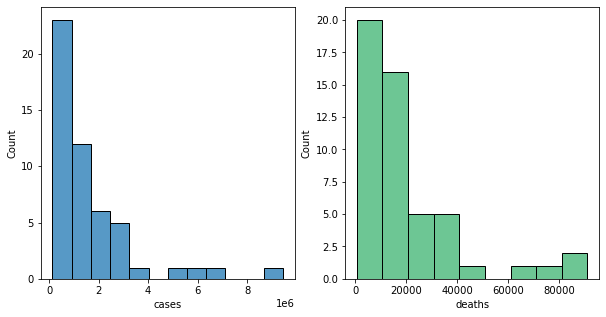

In [25]:
#the cases and deaths are highly related to the population size so are needed to be normalized
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(ax=axes[0], data = eda_df, x = 'cases')

sns.histplot(ax=axes[1], data = eda_df, x = 'deaths', color = 'mediumseagreen')

In [26]:
#First, normalize the number of cases and deaths by states population
eda_df['avg_pop_estimate'] = (eda_df['pop_estimate_2020'] + eda_df['pop_estimate_2021'])/2
eda_df['cases_rate'] = eda_df['cases']/eda_df['avg_pop_estimate']
eda_df['deaths_rate'] = eda_df['deaths']/eda_df['avg_pop_estimate']

eda_df = eda_df.drop(columns=['pop_estimate_2020','pop_estimate_2021', 'under_18_poverty_count','all_ages_poverty_count'])
eda_df.head()

,state,date,cases,deaths,all_ages_poverty_pct,under_18_poverty_pct,median_household_income,avg_pop_estimate,cases_rate,deaths_rate
0,Alabama,2022-05-20,1307883,19645,14.9,20.9,53958,5032340.0,0.259896,0.003904
1,Alaska,2022-05-20,256415,1246,9.6,12.3,79961,732557.0,0.350027,0.001701
2,Arizona,2022-05-20,2038129,30259,12.8,17.6,64652,7227151.0,0.282010,0.004187
3,Arkansas,2022-05-20,840151,11432,15.2,20.8,51146,3019061.5,0.278282,0.003787
4,California,2022-05-20,9449358,91203,11.5,14.6,83001,39368787.0,0.240022,0.002317


<AxesSubplot:xlabel='deaths_rate', ylabel='Count'>

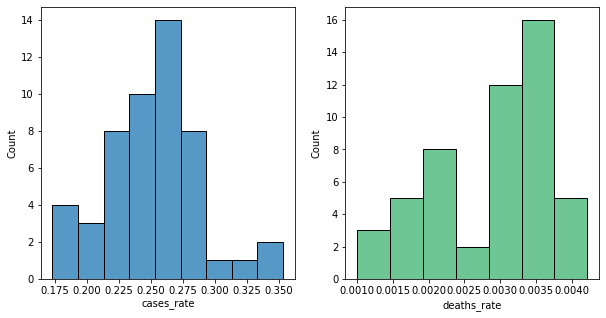

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(ax=axes[0], data = eda_df, x = 'cases_rate')

sns.histplot(ax=axes[1], data = eda_df, x = 'deaths_rate', color = 'mediumseagreen')

<AxesSubplot:xlabel='median_household_income', ylabel='Count'>

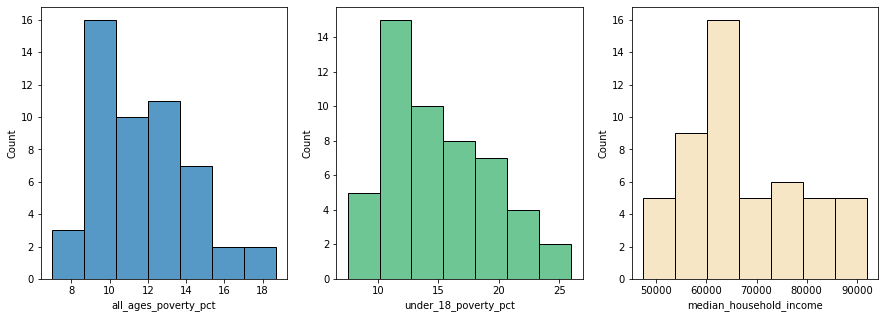

In [28]:
#rest of the variables looks normal
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(ax=axes[0], data = eda_df, x = 'all_ages_poverty_pct')

sns.histplot(ax=axes[1], data = eda_df, x = 'under_18_poverty_pct',color = 'mediumseagreen')

sns.histplot(ax=axes[2], data = eda_df, x = 'median_household_income',color = 'wheat')

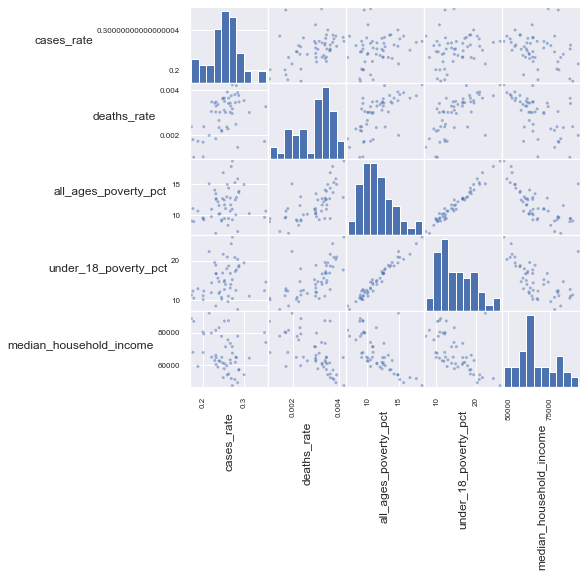

In [29]:
#Searching some possible relationship
sns.set(rc={'figure.figsize':(7,7)})
fig = pd.plotting.scatter_matrix(eda_df[['cases_rate','deaths_rate','all_ages_poverty_pct','under_18_poverty_pct','median_household_income']])
for ax in fig.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

<AxesSubplot:xlabel='median_household_income', ylabel='deaths_rate'>

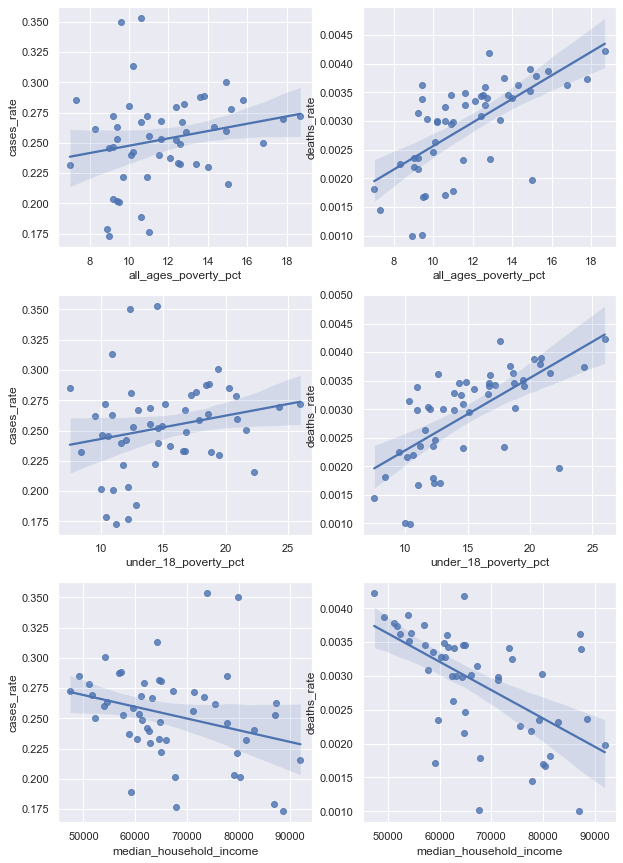

In [30]:
#some relationships we are interseted in
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

sns.regplot(ax = axes[0,0], data = eda_df, x = 'all_ages_poverty_pct',y = 'cases_rate')

sns.regplot(ax = axes[0,1], data = eda_df, x = 'all_ages_poverty_pct',y = 'deaths_rate')

sns.regplot(ax = axes[1,0], data = eda_df, x = 'under_18_poverty_pct',y = 'cases_rate')

sns.regplot(ax = axes[1,1], data = eda_df, x = 'under_18_poverty_pct',y = 'deaths_rate')

sns.regplot(ax = axes[2,0], data = eda_df, x = 'median_household_income',y = 'cases_rate')

sns.regplot(ax = axes[2,1], data = eda_df, x = 'median_household_income',y = 'deaths_rate')

# Analysis and Observations
First two-rows we are looking at the poverty_percentage against infection_rate and death rate. From this we can see that there's positive correlation between covid infection vs poverty percentage. What this mean is that for states that have higher poverty percentage there is also a higher number of infection.

Next we look at infection rate against median household income. This time there is a negative correlation in the data. Meaning household with higher income are lesslikely to contract Covid. Across our data for 50 states, there is a 5% increases in infection rate for median income of \$50,000 and \$90,000.

These graphs support our hypothesis that Covid have a higher impact on households that are in poverty.

In [31]:
dependent, predictor = patsy.dmatrices('cases_rate ~ all_ages_poverty_pct', eda_df)
model = sm.OLS(dependent,predictor)

result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             cases_rate   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     2.257
Date:                Sat, 21 May 2022   Prob (F-statistic):              0.139
Time:                        00:32:27   Log-Likelihood:                 96.445
No. Observations:                  51   AIC:                            -188.9
Df Residuals:                      49   BIC:                            -185.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.2173 